Import Libraries

In [19]:
import os
os.environ["PYTHONWARNINGS"] = "ignore"

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import mne
from sklearn.utils import resample
from mne.filter import filter_data
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split,cross_validate, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from scipy.stats import ttest_rel
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, accuracy_score, precision_score,recall_score, f1_score, confusion_matrix, make_scorer, ConfusionMatrixDisplay, roc_curve, auc, precision_recall_curve, average_precision_score

Summary file parsing to extract seizure start and end times

In [2]:
def extract_seizure_events_from_txt(folder_path):
    """
    Parses all .txt summary files in a folder to extract seizure start/end times
    for each corresponding .edf file.

    """
    seizure_info = {}

    txt_files = [f for f in os.listdir(folder_path) if f.endswith('.txt')]
    if not txt_files:
        raise FileNotFoundError("No .txt summary files found in the folder.")

    for txt_file in txt_files:
        summary_file = os.path.join(folder_path, txt_file)
        current_file = None
        current_start = None

        with open(summary_file, "r") as f:
            for line in f:
                line = line.strip()

                if line.startswith("File Name:"):
                    current_file = line.split(":", 1)[1].strip()
                    if current_file not in seizure_info:
                        seizure_info[current_file] = []

                elif line.startswith("Seizure Start Time:"):
                    current_start = int(line.split(":", 1)[1].strip().split()[0])

                elif line.startswith("Seizure End Time:") and current_start is not None:
                    end_time = int(line.split(":", 1)[1].strip().split()[0])
                    seizure_info[current_file].append((current_start, end_time))
                    current_start = None 

    return seizure_info


Data Loading

In [3]:
def load_edf_with_seizures(edf_path, seizure_times, sampling_rate=256):
    """
    Load EDF file and return data with seizure annotations.
    Keeps only first occurrence of duplicate base channel names.
    """
    raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)

    base_names = [name.split('-')[0] + '-' + name.split('-')[1] if name.count('-') >= 2 else name for name in raw.ch_names]

    seen = set()
    keep = []
    for i, name in enumerate(base_names):
        if name not in seen:
            seen.add(name)
            keep.append(raw.ch_names[i])

    raw.pick_channels(keep)

    seizure_samples = [
        (int(start * sampling_rate), int(end * sampling_rate))
        for start, end in seizure_times
    ]

    return {
        'raw': raw,
        'seizure_samples': seizure_samples
    }


In [4]:
def batch_load_edf_with_seizures(data_folder):
    """
    Loads all .edf files in a folder with their seizure annotations.

    """
    seizure_info = extract_seizure_events_from_txt(data_folder)
    loaded_data = {}

    for fname in os.listdir(data_folder):
        if fname.endswith('.edf') and fname in seizure_info:
            edf_path = os.path.join(data_folder, fname)
            seizure_times = seizure_info[fname]

            try:
                result = load_edf_with_seizures(edf_path, seizure_times)
                loaded_data[fname] = result
                print(f"Loaded {fname} with {len(result['seizure_samples'])} seizure intervals")
            except Exception as e:
                print(f"Failed to load {fname}: {e}")

    return loaded_data

Data Processing

In [5]:
def process_single_file(raw, edf_filename, output_folder, selected_channels, seizure_windows):
    """
    Preprocesses EEG and saves .npz with metadata.
    """
    os.makedirs(output_folder, exist_ok=True)

    raw.pick_channels(selected_channels)
    data = raw.get_data()
    sfreq = raw.info['sfreq']


    data = filter_data(data, sfreq=sfreq, l_freq=0.5, h_freq=25.0, verbose=False)

    base_name = os.path.splitext(edf_filename)[0]
    save_path = os.path.join(output_folder, f"{base_name}_preprocessed.npz")
    np.savez(save_path,
             data=data,
             seizure_windows=np.array(seizure_windows, dtype=np.int32),
             sampling_rate=sfreq,
             channels=np.array(selected_channels),
             file_name=edf_filename)

    return data

In [6]:
def preprocess_and_save(edf_folder):
    """
    Batch preprocesses and saves all EDF files in folder.
    Skips files missing required channels.
    """
    output_folder = os.path.join(edf_folder, 'preprocessed')
    os.makedirs(output_folder, exist_ok=True)

    selected_channels = [
        'FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1',
        'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1',
        'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2',
        'FP2-F8', 'F8-T8',  'P8-O2',
        'FZ-CZ', 'CZ-PZ'
    ]

    seizure_dict = extract_seizure_events_from_txt(edf_folder)

    for fname in os.listdir(edf_folder):
        if fname.endswith('.edf'):
            edf_path = os.path.join(edf_folder, fname)
            seizure_times = seizure_dict.get(fname, [])

            try:
                # Load with filtering of duplicate channels
                data_obj = load_edf_with_seizures(edf_path, seizure_times)
                raw = data_obj['raw']

                # Check if all selected channels are present (after cleaning)
                available_channels = set(raw.ch_names)
                if not all(chan in available_channels for chan in selected_channels):
                    print(f"Skipping {fname}: missing expected channels.")
                    continue

                # Now process and save
                process_single_file(
                    raw=raw,
                    edf_filename=fname,
                    output_folder=output_folder,
                    selected_channels=selected_channels,
                    seizure_windows=data_obj['seizure_samples']
                )

                base_name = os.path.splitext(fname)[0]
                print(f"Saved to: {os.path.join(output_folder, base_name + '_preprocessed.npz')}\n")

            except Exception as e:
                print(f"Failed to process {fname}: {e}")


In [7]:
def segment_and_label(eeg_data, seizure_windows, window_duration=2.0, sampling_rate=256, overlap=0.5):
    """
    Segments EEG into overlapping windows and labels them
    """
    window_size = int(window_duration*sampling_rate)
    step_size = int(window_size*(1-overlap))
    channels, total_samples = eeg_data.shape
    X,y = [], []
    for start in range(0, total_samples-window_size + 1, step_size):
        end = start + window_size
        window = eeg_data[:, start:end]

        label = 0
        for sz_start, sz_end in seizure_windows:
            if end > sz_start and start < sz_end:
                label = 1
                break
        X.append(window) 
        y.append(label)

    X = np.stack(X)
    y = np.stack(y)

    return X,y

In [8]:
def batch_segment_preprocessed(folder_path):
    """
    Segments all preprocessed .npz files in 'preprocessed/' subfolder
    into 2s windows and labels them.
    """
    preprocessed_folder = os.path.join(folder_path, 'preprocessed')
    output_folder = os.path.join(folder_path, 'segmented')
    os.makedirs(output_folder, exist_ok=True)

    for fname in os.listdir(preprocessed_folder):
        if fname.endswith("_preprocessed.npz"):
            full_path = os.path.join(preprocessed_folder, fname)

            try:
                npz = np.load(full_path, allow_pickle=True)
                eeg = npz['data']
                sz_windows = npz["seizure_windows"]
                sfreq = int(npz['sampling_rate'])
                file_name = str(npz['file_name'])
                channels = list(npz['channels'])
                X, y = segment_and_label(eeg_data=eeg,
                         seizure_windows=sz_windows,
                         window_duration=2.0,
                         sampling_rate=sfreq,
                         overlap=0.5)
                base_name = fname.replace('_preprocessed.npz', '')
                save_path = os.path.join(output_folder, f"{base_name}_segmented.npz")
                np.savez(save_path,
                         X=X,
                         y=y,
                         sampling_rate=sfreq,
                         channels=channels,
                         file_name=file_name)

                print(f"Segmented and saved: {save_path}")

            except Exception as e:
                print(f"Failed on {fname}: {e}")


Concatenate all NPZ files

In [2]:

def load_segmented_dataset(folder_path):
    """
    Loads and concatenates all segmented .npz files in a folder.
    """
    X_list, y_list = [], []

    for fname in os.listdir(folder_path):
        if fname.endswith('_segmented.npz'):
            npz_path = os.path.join(folder_path, fname)
            try:
                npz = np.load(npz_path)
                X = npz['X']
                y = npz['y']
                X_list.append(X)
                y_list.append(y)
            except Exception as e:
                print(f"Could not load {fname}: {e}")

    X_total = np.concatenate(X_list, axis=0)
    y_total = np.concatenate(y_list, axis=0)

    return X_total, y_total

############ Calling The Functions ############

In [11]:
extract_seizure_events_from_txt("/Users/folasewaabdulsalam/Seizure_Onset_Prediction/data")

{'chb06_01.edf': [],
 'chb06_02.edf': [],
 'chb06_03.edf': [],
 'chb06_04.edf': [],
 'chb06_05.edf': [],
 'chb06_06.edf': [],
 'chb06_07.edf': [],
 'chb06_08.edf': [],
 'chb06_09.edf': [],
 'chb06_10.edf': [],
 'chb06_12.edf': [],
 'chb06_13.edf': [],
 'chb06_14.edf': [],
 'chb06_15.edf': [],
 'chb06_16.edf': [],
 'chb06_17.edf': [],
 'chb06_18.edf': [],
 'chb06_24.edf': [],
 'chb05_01.edf': [],
 'chb05_02.edf': [],
 'chb05_03.edf': [],
 'chb05_04.edf': [],
 'chb05_05.edf': [],
 'chb05_06.edf': [(417, 532)],
 'chb05_07.edf': [],
 'chb05_08.edf': [],
 'chb05_09.edf': [],
 'chb05_10.edf': [],
 'chb05_11.edf': [],
 'chb05_12.edf': [],
 'chb05_13.edf': [(1086, 1196)],
 'chb05_14.edf': [],
 'chb05_15.edf': [],
 'chb05_16.edf': [(2317, 2413)],
 'chb05_17.edf': [(2451, 2571)],
 'chb05_18.edf': [],
 'chb05_19.edf': [],
 'chb05_20.edf': [],
 'chb05_21.edf': [],
 'chb05_22.edf': [(2348, 2465)],
 'chb05_23.edf': [],
 'chb05_24.edf': [],
 'chb05_25.edf': [],
 'chb05_26.edf': [],
 'chb05_27.edf': [

In [12]:
batch_load_edf_with_seizures("/Users/folasewaabdulsalam/Seizure_Onset_Prediction/data")

/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_66436/2455710421.py:6: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Loaded chb01_43.edf with 0 seizure intervals
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Loaded chb02_05.edf with 0 seizure intervals


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_66436/2455710421.py:6: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_66436/2455710421.py:6: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Loaded chb02_14.edf with 0 seizure intervals
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_66436/2455710421.py:6: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Loaded chb05_22.edf with 1 seizure intervals


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_66436/2455710421.py:6: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Loaded chb04_05.edf with 1 seizure intervals
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Loaded chb01_21.edf with 1 seizure intervals


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_66436/2455710421.py:6: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_66436/2455710421.py:6: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Loaded chb06_01.edf with 0 seizure intervals
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Loaded chb01_26.edf with 1 seizure intervals


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_66436/2455710421.py:6: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_66436/2455710421.py:6: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Loaded chb04_28.edf with 0 seizure intervals
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Loaded chb01_18.edf with 1 seizure intervals


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_66436/2455710421.py:6: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_66436/2455710421.py:6: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Loaded chb06_09.edf with 0 seizure intervals
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Loaded chb01_15.edf with 1 seizure intervals


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_66436/2455710421.py:6: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_66436/2455710421.py:6: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Loaded chb01_03.edf with 1 seizure intervals


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_66436/2455710421.py:6: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Loaded chb01_16.edf with 1 seizure intervals


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_66436/2455710421.py:6: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Loaded chb06_18.edf with 0 seizure intervals


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_66436/2455710421.py:6: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Loaded chb06_24.edf with 0 seizure intervals
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Loaded chb01_04.edf with 1 seizure intervals


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_66436/2455710421.py:6: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_66436/2455710421.py:6: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Loaded chb04_08.edf with 1 seizure intervals
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Loaded chb05_13.edf with 1 seizure intervals


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_66436/2455710421.py:6: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)
/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_66436/2455710421.py:6: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Loaded chb05_06.edf with 1 seizure intervals


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_66436/2455710421.py:6: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Loaded chb02_19.edf with 1 seizure intervals


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_66436/2455710421.py:6: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Loaded chb02_16+.edf with 1 seizure intervals


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_66436/2455710421.py:6: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Loaded chb02_35.edf with 0 seizure intervals


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_66436/2455710421.py:6: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Loaded chb05_16.edf with 1 seizure intervals


/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_66436/2455710421.py:6: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Loaded chb05_17.edf with 1 seizure intervals


{'chb01_43.edf': {'raw': <RawEDF | chb01_43.edf, 22 x 921600 (3600.0 s), ~154.7 MiB, data loaded>,
  'seizure_samples': []},
 'chb02_05.edf': {'raw': <RawEDF | chb02_05.edf, 22 x 921600 (3600.0 s), ~154.7 MiB, data loaded>,
  'seizure_samples': []},
 'chb02_14.edf': {'raw': <RawEDF | chb02_14.edf, 22 x 921600 (3600.0 s), ~154.7 MiB, data loaded>,
  'seizure_samples': []},
 'chb05_22.edf': {'raw': <RawEDF | chb05_22.edf, 22 x 921600 (3600.0 s), ~154.7 MiB, data loaded>,
  'seizure_samples': [(601088, 631040)]},
 'chb04_05.edf': {'raw': <RawEDF | chb04_05.edf, 22 x 2441216 (9536.0 s), ~409.8 MiB, data loaded>,
  'seizure_samples': [(1997824, 2010368)]},
 'chb01_21.edf': {'raw': <RawEDF | chb01_21.edf, 22 x 921600 (3600.0 s), ~154.7 MiB, data loaded>,
  'seizure_samples': [(83712, 107520)]},
 'chb06_01.edf': {'raw': <RawEDF | chb06_01.edf, 22 x 3693312 (14427.0 s), ~619.9 MiB, data loaded>,
  'seizure_samples': []},
 'chb01_26.edf': {'raw': <RawEDF | chb01_26.edf, 22 x 595200 (2325.0 s), 

In [12]:
preprocess_and_save("C:\\Users\\itama\\Desktop\\data analysis for neuroscience course\\Seizure_Onset_Prediction\\data")

C:\Users\itama\AppData\Local\Temp\ipykernel_12904\2455710421.py:6: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Saved to: C:\Users\itama\Desktop\data analysis for neuroscience course\Seizure_Onset_Prediction\data\preprocessed\chb01_03_preprocessed.npz



C:\Users\itama\AppData\Local\Temp\ipykernel_12904\2455710421.py:6: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Saved to: C:\Users\itama\Desktop\data analysis for neuroscience course\Seizure_Onset_Prediction\data\preprocessed\chb01_04_preprocessed.npz



C:\Users\itama\AppData\Local\Temp\ipykernel_12904\2455710421.py:6: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Saved to: C:\Users\itama\Desktop\data analysis for neuroscience course\Seizure_Onset_Prediction\data\preprocessed\chb01_15_preprocessed.npz

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\itama\AppData\Local\Temp\ipykernel_12904\2455710421.py:6: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Saved to: C:\Users\itama\Desktop\data analysis for neuroscience course\Seizure_Onset_Prediction\data\preprocessed\chb01_16_preprocessed.npz

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\itama\AppData\Local\Temp\ipykernel_12904\2455710421.py:6: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Saved to: C:\Users\itama\Desktop\data analysis for neuroscience course\Seizure_Onset_Prediction\data\preprocessed\chb01_18_preprocessed.npz

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\itama\AppData\Local\Temp\ipykernel_12904\2455710421.py:6: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Saved to: C:\Users\itama\Desktop\data analysis for neuroscience course\Seizure_Onset_Prediction\data\preprocessed\chb01_21_preprocessed.npz

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\itama\AppData\Local\Temp\ipykernel_12904\2455710421.py:6: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


Saved to: C:\Users\itama\Desktop\data analysis for neuroscience course\Seizure_Onset_Prediction\data\preprocessed\chb01_26_preprocessed.npz

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\itama\AppData\Local\Temp\ipykernel_12904\2455710421.py:6: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Saved to: C:\Users\itama\Desktop\data analysis for neuroscience course\Seizure_Onset_Prediction\data\preprocessed\chb02_05_preprocessed.npz

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\itama\AppData\Local\Temp\ipykernel_12904\2455710421.py:6: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Saved to: C:\Users\itama\Desktop\data analysis for neuroscience course\Seizure_Onset_Prediction\data\preprocessed\chb02_14_preprocessed.npz

NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).


C:\Users\itama\AppData\Local\Temp\ipykernel_12904\2455710421.py:6: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Saved to: C:\Users\itama\Desktop\data analysis for neuroscience course\Seizure_Onset_Prediction\data\preprocessed\chb02_16+_preprocessed.npz



C:\Users\itama\AppData\Local\Temp\ipykernel_12904\2455710421.py:6: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Saved to: C:\Users\itama\Desktop\data analysis for neuroscience course\Seizure_Onset_Prediction\data\preprocessed\chb02_19_preprocessed.npz



C:\Users\itama\AppData\Local\Temp\ipykernel_12904\2455710421.py:6: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_path, preload=True, verbose=False)


NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
NOTE: pick_channels() is a legacy function. New code should use inst.pick(...).
Saved to: C:\Users\itama\Desktop\data analysis for neuroscience course\Seizure_Onset_Prediction\data\preprocessed\chb02_35_preprocessed.npz



In [13]:
batch_segment_preprocessed("C:\\Users\\itama\\Desktop\\data analysis for neuroscience course\\Seizure_Onset_Prediction\\data")

Segmented and saved: C:\Users\itama\Desktop\data analysis for neuroscience course\Seizure_Onset_Prediction\data\segmented\chb01_03_segmented.npz
Segmented and saved: C:\Users\itama\Desktop\data analysis for neuroscience course\Seizure_Onset_Prediction\data\segmented\chb01_04_segmented.npz
Segmented and saved: C:\Users\itama\Desktop\data analysis for neuroscience course\Seizure_Onset_Prediction\data\segmented\chb01_15_segmented.npz
Segmented and saved: C:\Users\itama\Desktop\data analysis for neuroscience course\Seizure_Onset_Prediction\data\segmented\chb01_16_segmented.npz
Segmented and saved: C:\Users\itama\Desktop\data analysis for neuroscience course\Seizure_Onset_Prediction\data\segmented\chb01_18_segmented.npz
Segmented and saved: C:\Users\itama\Desktop\data analysis for neuroscience course\Seizure_Onset_Prediction\data\segmented\chb01_21_segmented.npz
Segmented and saved: C:\Users\itama\Desktop\data analysis for neuroscience course\Seizure_Onset_Prediction\data\segmented\chb01_26

In [3]:
X_total, y_total = load_segmented_dataset("/Users/folasewaabdulsalam/Seizure_Onset_Prediction/data/segmented")

Training and Evaluation

In [4]:

def downsample_majority(X, y, majority_label=0, minority_label=1, majority_n=1500):
    """
    Downsamples the majority class and returns the balanced dataset.
    """
 
    X_major = X[y == majority_label]
    y_major = y[y == majority_label]
    X_minor = X[y == minority_label]
    y_minor = y[y == minority_label]


    X_major_down, y_major_down = resample(
        X_major, y_major,
        replace=False,
        n_samples=majority_n,
        random_state=42
    )

    X_balanced = np.concatenate([X_major_down, X_minor], axis=0)
    y_balanced = np.concatenate([y_major_down, y_minor], axis=0)

    return X_balanced, y_balanced


In [5]:
X_bal, y_bal = downsample_majority(X_total, y_total)


In [22]:

def specificity_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    tn = cm[0, 0]
    fp = cm[0, 1]
    return tn / (tn + fp + 1e-10)

def train_ml(X_total, y_total):
    """
    Trains classical ML models (Logistic Regression, Random Forest, SVM) on flattened EEG data.
    """
    X_total_flat = X_total.reshape(X_total.shape[0], -1)
    X_train, X_temp, y_train, y_temp = train_test_split(X_total_flat, y_total, test_size=0.3, stratify=y_total, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

    models = {
        'LogisticRegression': LogisticRegression(class_weight="balanced", max_iter=1000),
        'RandomForest': RandomForestClassifier(n_estimators=100),
        'SVM': SVC()
    }

    scoring = {
        'accuracy': 'accuracy',
        'precision': 'precision',
        'recall': 'recall',
        'f1': 'f1'
    }

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    trained_models = {}

    for name, model in models.items():
        print(f"\n==== {name} ====")
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('clf', model)
        ])

        cv_results = cross_validate(pipeline, X_train, y_train, cv=cv, scoring=scoring)
        for metric in scoring:
            scores = cv_results[f'test_{metric}']
            print(f"{metric.capitalize()} (CV): {scores.mean():.4f} ± {scores.std():.4f}")

        pipeline.fit(X_train, y_train)
        trained_models[name] = pipeline  # store fitted model
        y_val_pred = pipeline.predict(X_val)

        acc = accuracy_score(y_val, y_val_pred)
        prec = precision_score(y_val, y_val_pred)
        rec = recall_score(y_val, y_val_pred)
        spec = specificity_score(y_val, y_val_pred)
        f1 = f1_score(y_val, y_val_pred)

        print(f"\nValidation Set Performance:")
        print(f"Accuracy:    {acc:.4f}")
        print(f"Precision:   {prec:.4f}")
        print(f"Recall:      {rec:.4f}")
        print(f"Specificity: {spec:.4f}")
        print(f"F1 Score:    {f1:.4f}")

        y_test_pred = pipeline.predict(X_test)
        acc = accuracy_score(y_test, y_test_pred)
        prec = precision_score(y_test, y_test_pred)
        rec = recall_score(y_test, y_test_pred)
        spec = specificity_score(y_test, y_test_pred)
        f1 = f1_score(y_test, y_test_pred)

        print(f"\nTest Set Performance:")
        print(f"Accuracy:    {acc:.4f}")
        print(f"Precision:   {prec:.4f}")
        print(f"Recall:      {rec:.4f}")
        print(f"Specificity: {spec:.4f}")
        print(f"F1 Score:    {f1:.4f}")




In [8]:
train_ml(X_bal, y_bal)



==== LogisticRegression ====
Accuracy (CV): 0.6121 ± 0.0129
Precision (CV): 0.6231 ± 0.0277
Recall (CV): 0.3894 ± 0.0111
F1 (CV): 0.4789 ± 0.0105

Validation Set Performance:
Accuracy:    0.5855
Precision:   0.5672
Recall:      0.4000
Specificity: 0.7422
F1 Score:    0.4691

Test Set Performance:
Accuracy:    0.5880
Precision:   0.5683
Recall:      0.4158
Specificity: 0.7333
F1 Score:    0.4802

==== RandomForest ====
Accuracy (CV): 0.8275 ± 0.0162
Precision (CV): 0.7741 ± 0.0237
Recall (CV): 0.8815 ± 0.0161
F1 (CV): 0.8240 ± 0.0143

Validation Set Performance:
Accuracy:    0.7687
Precision:   0.7117
Recall:      0.8316
Specificity: 0.7156
F1 Score:    0.7670

Test Set Performance:
Accuracy:    0.8289
Precision:   0.7742
Recall:      0.8842
Specificity: 0.7822
F1 Score:    0.8256

==== SVM ====
Accuracy (CV): 0.8218 ± 0.0157
Precision (CV): 0.8577 ± 0.0305
Recall (CV): 0.7337 ± 0.0219
F1 (CV): 0.7903 ± 0.0169

Validation Set Performance:
Accuracy:    0.7783
Precision:   0.7816
Recall:

In [21]:
#saving the balanced data
np.savez_compressed("balanced_dataset1.npz", X=X_bal, y=y_bal)


#Optimizing the model

In [32]:
#hyperparamter tuning with pca

models = {
    'LogisticRegression': LogisticRegression(class_weight='balanced', max_iter=1000),
    'RandomForest': RandomForestClassifier(),
    'SVM': SVC(class_weight='balanced')}

param_grid = {
    'LogisticRegression': {'pca__n_components': [10, 20, 30, 50],'clf__C': [0.01, 0.1, 1, 10], 'clf__penalty': ['l2'], 'clf__solver': ['lbfgs']},
    'RandomForest': {'pca__n_components': [10, 20, 30, 50],'clf__n_estimators': [100,200], 'clf__max_depth': [None, 10, 20]},
    'SVM': {'pca__n_components': [10, 20, 30, 50],'clf__C': [0.1,1,10], 'clf__kernel': ['rbf', 'linear'], 'clf__gamma': ['scale', 'auto']}}


def train_ml_optimized(X_total, y_total):
    """
    Here is the optimized training function for the models
    """
    X_total_flat = X_total.reshape(X_total.shape[0], -1)
    X_train, X_temp, y_train, y_temp = train_test_split(X_total_flat, y_total, test_size=0.3, stratify=y_total, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, stratify=y_temp, random_state=42)

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    test_f1_scores = {}
    results = {}

    for name in models:
        print(f"\n==== {name} ====")
        pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('pca', PCA()),
            ('clf', models[name])
        ])
        grid = GridSearchCV(
            pipeline,
            param_grid[name],
            cv=cv,
            scoring='f1',
            n_jobs=-1
        )
        grid.fit(X_train, y_train)
        best_model = grid.best_estimator_
        print(f"Best Params: {grid.best_params_}")

        y_val_pred = best_model.predict(X_val)
        print("\nValidation Set Performance:")
        print(f"Accuracy:    {accuracy_score(y_val, y_val_pred):.4f}")
        print(f"Precision:   {precision_score(y_val, y_val_pred):.4f}")
        print(f"Recall:      {recall_score(y_val, y_val_pred):.4f}")
        print(f"Specificity: {specificity_score(y_val, y_val_pred):.4f}")
        print(f"F1 Score:    {f1_score(y_val, y_val_pred):.4f}")

        y_test_pred = best_model.predict(X_test)
        test_f1 = f1_score(y_test, y_test_pred)
        test_f1_scores[name] = test_f1

        print("\nTest Set Performance:")
        print(f"Accuracy:    {accuracy_score(y_test, y_test_pred):.4f}")
        print(f"Precision:   {precision_score(y_test, y_test_pred):.4f}")
        print(f"Recall:      {recall_score(y_test, y_test_pred):.4f}")
        print(f"Specificity: {specificity_score(y_test, y_test_pred):.4f}")
        print(f"F1 Score:    {f1_score(y_test, y_test_pred):.4f}")

        tuned_pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('pca', PCA()),
            ('clf', models[name].__class__(**getattr(models[name], 'get_params', lambda: {})()))
        ])

        tuned_pipeline.set_params(**grid.best_params_)
        cv_scores = cross_val_score(
            tuned_pipeline, X_train, y_train, cv=cv, scoring='f1', n_jobs=-1
        )
        results[name] = cv_scores
        

        if name == 'SVM':
            svm_best_model = best_model
            svm_y_test_pred = y_test_pred
            
    results_df = pd.DataFrame(results)
    return svm_best_model, X_test, y_test, svm_y_test_pred, test_f1_scores, results_df

  
    


In [33]:
best_model, X_test, y_test, y_test_pred, test_f1_scores, results_df = train_ml_optimized(X_bal, y_bal)



==== LogisticRegression ====
Best Params: {'clf__C': 1, 'clf__penalty': 'l2', 'clf__solver': 'lbfgs', 'pca__n_components': 30}

Validation Set Performance:
Accuracy:    0.5325
Precision:   0.4882
Recall:      0.4368
Specificity: 0.6133
F1 Score:    0.4611

Test Set Performance:
Accuracy:    0.5494
Precision:   0.5086
Recall:      0.4684
Specificity: 0.6178
F1 Score:    0.4877

==== RandomForest ====
Best Params: {'clf__max_depth': None, 'clf__n_estimators': 100, 'pca__n_components': 50}

Validation Set Performance:
Accuracy:    0.7735
Precision:   0.7222
Recall:      0.8211
Specificity: 0.7333
F1 Score:    0.7685

Test Set Performance:
Accuracy:    0.8337
Precision:   0.7923
Recall:      0.8632
Specificity: 0.8089
F1 Score:    0.8262

==== SVM ====


/Users/folasewaabdulsalam/Seizure_Onset_Prediction/venv/lib/python3.13/site-packages/joblib/externals/loky/process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best Params: {'clf__C': 10, 'clf__gamma': 'scale', 'clf__kernel': 'rbf', 'pca__n_components': 50}

Validation Set Performance:
Accuracy:    0.8434
Precision:   0.8882
Recall:      0.7526
Specificity: 0.9200
F1 Score:    0.8148

Test Set Performance:
Accuracy:    0.8602
Precision:   0.8750
Recall:      0.8105
Specificity: 0.9022
F1 Score:    0.8415


Visualizations

/var/folders/2r/22chk4fn06j2bd_2pbrv5vcm0000gn/T/ipykernel_13209/2914234878.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


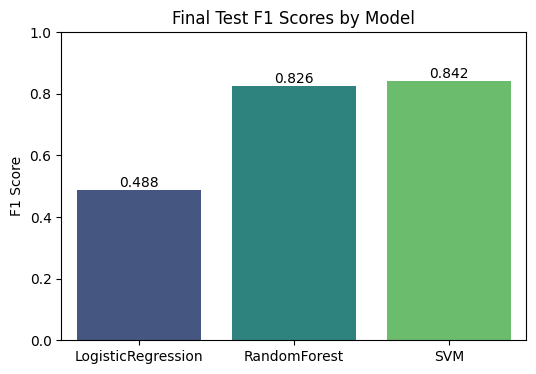

In [37]:
plt.figure(figsize=(6, 4))
sns.barplot(
    x=list(test_f1_scores.keys()),
    y=list(test_f1_scores.values()),
    palette="viridis"
)
plt.ylabel("F1 Score")
plt.title("Final Test F1 Scores by Model")
plt.ylim(0, 1)
for i, val in enumerate(test_f1_scores.values()):
    plt.text(i, val + 0.01, f"{val:.3f}", ha='center', fontsize=10)
plt.show()

In [29]:
def _get_scores_for_binary_roc(model, X):
    """
    Returns a continuous score for the positive class:
    - decision_function if available
    - otherwise the probability for class 1 (or the 'positive' label if provided by caller)
    """
    if hasattr(model, "decision_function"):
        s = model.decision_function(X)
        if s.ndim == 2 and s.shape[1] == 2:
            s = s[:, 1]
        return s
    if hasattr(model, "predict_proba"):
        proba = model.predict_proba(X)
        if proba.shape[1] == 2:
            return proba[:, 1]
    raise ValueError("Model must support decision_function or predict_proba for ROC.")

def plot_confusion_matrix_svm(y_true, y_pred, labels=None, normalize='true', title="SVM Confusion Matrix"):
    """
    Plots the confusion matrix of the svm model
    """
    cm = confusion_matrix(y_true, y_pred, labels=labels, normalize=normalize)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels if labels is not None else None)
    fig, ax = plt.subplots(figsize=(5.5, 5))
    disp.plot(ax=ax, cmap="Blues", colorbar=True, values_format=".2f" if normalize else "d")
    ax.set_title(title)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    plt.tight_layout()
    plt.show()

def plot_roc_auc_svm(y_true, y_score, pos_label=1, title="SVM ROC Curve"):
    """
    Plots the roc-auc curve
    """
    fpr, tpr, _ = roc_curve(y_true, y_score, pos_label=pos_label)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(5.5, 5))
    plt.plot(fpr, tpr, linewidth=2, label=f"AUC = {roc_auc:.3f}")
    plt.plot([0, 1], [0, 1], linestyle="--", linewidth=1)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(title)
    plt.legend(loc="lower right")
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

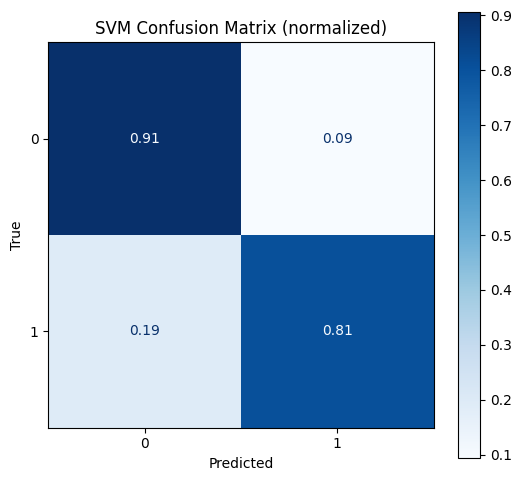

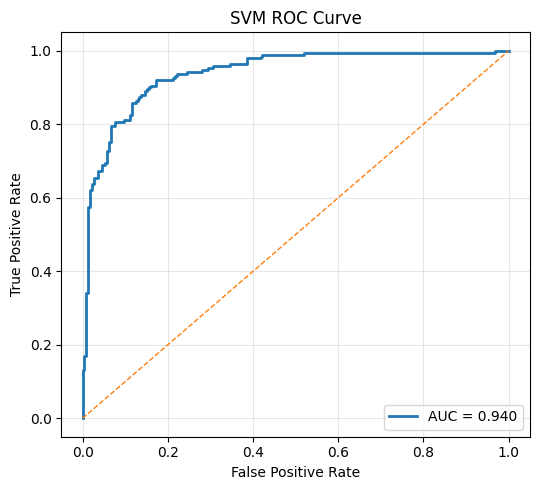

In [30]:
plot_confusion_matrix_svm(y_test, y_test_pred, labels=[0,1], normalize='true',
                          title="SVM Confusion Matrix (normalized)")
y_score = _get_scores_for_binary_roc(best_model, X_test)
plot_roc_auc_svm(y_test, y_score, pos_label=1, title="SVM ROC Curve")


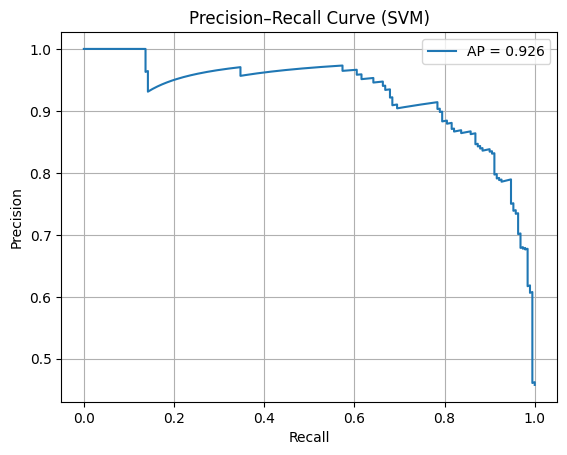

In [31]:
#pr-curve
y_score = _get_scores_for_binary_roc(best_model, X_test)
precision, recall, _ = precision_recall_curve(y_test, y_score)
ap_score = average_precision_score(y_test, y_score)

plt.figure()
plt.plot(recall, precision, label=f'AP = {ap_score:.3f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision–Recall Curve (SVM)')
plt.legend()
plt.grid(True)
plt.show()

Statistical Test

In [34]:
print(results_df)

   LogisticRegression  RandomForest       SVM
0            0.482143      0.826087  0.803738
1            0.485207      0.775726  0.826748
2            0.515406      0.813187  0.831804
3            0.484277      0.815427  0.802548
4            0.471299      0.811111  0.824615


In [35]:
model_names = list(results_df.columns)
comparisons = []
for i in range(len(model_names)):
    for j in range(i+1, len(model_names)):
        m1 = model_names[i]
        m2 = model_names[j]
        stat, p = ttest_rel(results_df[m1], results_df[m2])
        comparisons.append({
            'Model 1': m1,
            'Model 2': m2,
            't-statistic': stat,
            'p-value': p
        })

comparisons_df = pd.DataFrame(comparisons)
print(comparisons_df)

              Model 1       Model 2  t-statistic   p-value
0  LogisticRegression  RandomForest   -28.964456  0.000008
1  LogisticRegression           SVM   -45.151564  0.000001
2        RandomForest           SVM    -0.741750  0.499427


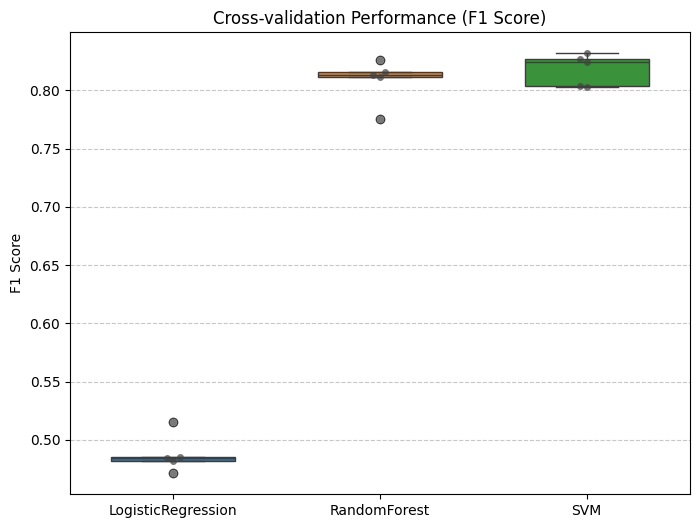

In [39]:
plt.figure(figsize=(8, 6))
sns.boxplot(data=results_df, width =0.6)
sns.swarmplot(data=results_df,color=".25", alpha=0.7) 
plt.ylabel("F1 Score")
plt.title("Cross-validation Performance (F1 Score)")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

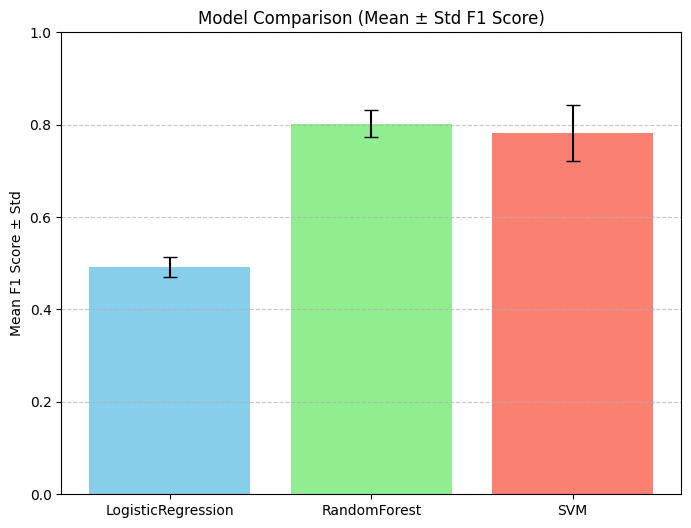

In [17]:
means = results_df.mean()
stds = results_df.std()

plt.figure(figsize=(8, 6))
plt.bar(means.index, means.values, yerr=stds.values, capsize=5, color=['skyblue', 'lightgreen', 'salmon'])
plt.ylabel("Mean F1 Score ± Std")
plt.title("Model Comparison (Mean ± Std F1 Score)")
plt.ylim(0, 1)  
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()